<a href="https://colab.research.google.com/github/sumitha9020/Elevatelabs_Tasks/blob/main/Projectrealtimesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# STEP 1: Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [4]:
# STEP 2: Download Dataset (ASL Alphabet)
# Download latest version from Kaggle
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)


100%|██████████| 1.03G/1.03G [00:26<00:00, 42.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [9]:
# STEP 2: Dataset Path Verification

# Set your KaggleHub dataset path
dataset_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1"

# Explore the first few levels
for root, dirs, files in os.walk(dataset_path):
    print(f"{root} | {len(dirs)} dirs | {len(files)} files")



/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1 | 2 dirs | 0 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train | 1 dirs | 0 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train | 29 dirs | 0 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/P | 0 dirs | 3000 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/K | 0 dirs | 3000 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/U | 0 dirs | 3000 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/Y | 0 dirs | 3000 files
/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train/A | 0 dirs | 3000 files
/root/.cache/kagglehub/datasets

In [12]:
base_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train"


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================================
# Data Augmentation + Validation Split
# ======================================
datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixel values
    rotation_range=15,       # random rotation
    width_shift_range=0.1,   # horizontal shift
    height_shift_range=0.1,  # vertical shift
    zoom_range=0.2,          # random zoom
    shear_range=0.1,         # shear transformations
    horizontal_flip=True,    # flip images horizontally
    validation_split=0.2     # 80-20 split for training & validation
)

# Set the dataset base path
base_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train"

# Create Training and Validation Generators
train = datagen.flow_from_directory(
    base_path,
    target_size=(128,128),   # resize all images
    batch_size=32,
    subset='training'        # 80% of data for training
)

val = datagen.flow_from_directory(
    base_path,
    target_size=(128,128),
    batch_size=32,
    subset='validation'      # 20% of data for validation
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [14]:
print("Classes loaded:", train.class_indices)
print("Total classes:", train.num_classes)


Classes loaded: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Total classes: 29


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Load Pretrained MobileNetV2
# ======================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Unfreeze only last 30 layers for fine-tuning (keeps training stable)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Step 2: Build Sequential Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),     # reduce feature maps to single vector
    Dropout(0.3),                 # regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train.num_classes, activation='softmax')  # 29 output classes
])

# Step 3: Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 4: Train Model

history = model.fit(
    train,
    validation_data=val,
    epochs=10
)

# Step 5: Evaluate & Save Model
loss, acc = model.evaluate(val)
print(f"✅ Validation Accuracy: {acc*100:.2f}% | Loss: {loss:.4f}")

model.save("asl_mobilenetv2_finetuned.keras")
print("✅ Model saved as asl_mobilenetv2_finetuned.keras")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,693 (9.25 MB)

 Trainable params: 1,694,109 (6.46 MB)

 Non-trainable params: 731,584 (2.79 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 478s 208ms/step - accuracy: 0.6607 - loss: 1.2150 - val_accuracy: 0.8333 - val_loss: 0.5912
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 436s 201ms/step - accuracy: 0.9617 - loss: 0.1252 - val_accuracy: 0.8549 - val_loss: 0.5629
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 435s 200ms/step - accuracy: 0.9757 - loss: 0.0753 - val_accuracy: 0.8778 - val_loss: 0.5295
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 432s 198ms/step - accuracy: 0.9829 - loss: 0.0542 - val_accuracy: 0.8628 - val_loss: 0.6403
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 433s 199ms/step - accuracy: 0.9861 - loss: 0.0448 - val_accuracy: 0.8839 - val_loss: 0.4818
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 436s 200ms/step - accuracy: 0.9870 - loss: 0.0411 - val_accuracy: 0.8808 - val_loss: 0.5988
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 434s 200ms/step - accuracy: 0.9885 - loss: 0.0366 - val_accuracy: 0.8790 - val_loss: 0.6492
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 429s 197ms/step - ac

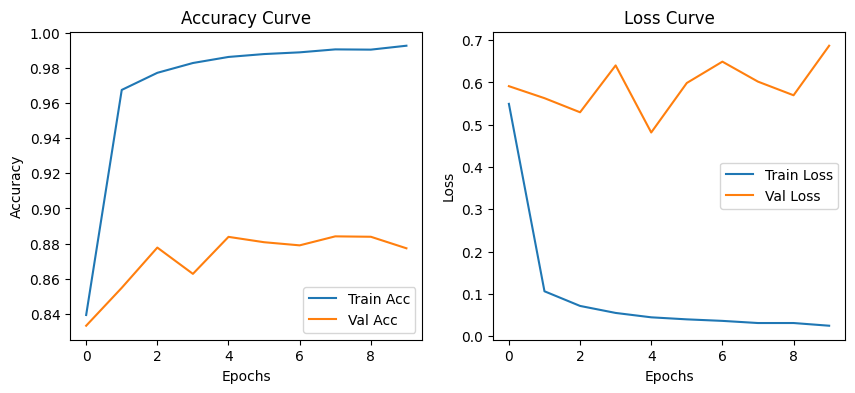

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.show()


Loaded classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
📸 Please allow camera access and click 'Capture' when ready...


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


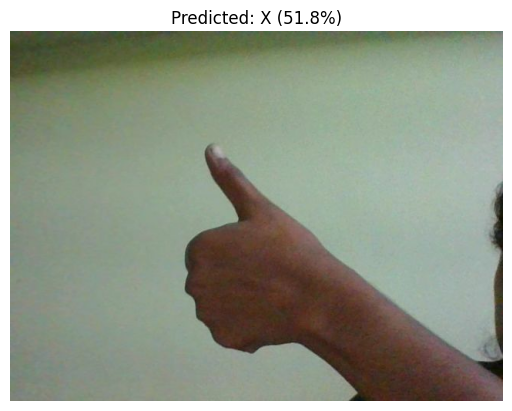

✅ Predicted Sign: X (51.77%)


In [18]:

# STEP 1: Import Required Libraries
import cv2
import numpy as np
import os
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.models import load_model

# STEP 2: Webcam Capture Function
def capture_image():
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);
      document.body.appendChild(div);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      video.remove(); capture.remove(); div.remove();
      return canvas.toDataURL('image/jpeg', 0.8);
    }
    takePhoto()
    ''')
    display(js)
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return frame

# STEP 3: Load Model and Labels
model_path = "asl_mobilenetv2_finetuned.keras"  # your saved model
model = load_model(model_path)

base_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train"
labels = sorted(os.listdir(base_path))
print("Loaded classes:", labels)

# STEP 4: Capture Image from Webcam
print("📸 Please allow camera access and click 'Capture' when ready...")
frame = capture_image()

# STEP 5: Preprocess and Predict

img = cv2.resize(frame, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=0)

preds = model.predict(img)
pred_class = labels[np.argmax(preds)]
confidence = np.max(preds)


# STEP 6: Display Prediction
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {pred_class} ({confidence*100:.1f}%)")
plt.axis('off')
plt.show()

print(f"✅ Predicted Sign: {pred_class} ({confidence*100:.2f}%)")


✅ Loaded classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
📸 Show signs one by one, press '📸 Capture Sign' for each, then '✅ Finish Word'


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


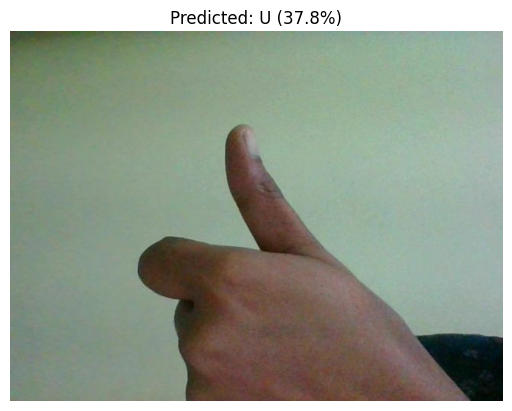

📝 Final Predicted Word: U


OSError: libespeak.so.1: cannot open shared object file: No such file or directory

In [22]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.models import load_model

# STEP 2: Webcam Capture Function
def capture_image():
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const finish = document.createElement('button');
      capture.textContent = '📸 Capture Sign';
      finish.textContent = '✅ Finish Word';
      div.appendChild(capture);
      div.appendChild(finish);
      document.body.appendChild(div);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      let images = [];
      let done = false;

      capture.onclick = () => {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        images.push(canvas.toDataURL('image/jpeg', 0.8));
      };

      finish.onclick = () => { done = true; };

      while (!done) {
        await new Promise(resolve => setTimeout(resolve, 100));
      }

      stream.getVideoTracks()[0].stop();
      video.remove(); div.remove();
      return images;
    }
    takePhoto()
    ''')
    display(js)
    data = eval_js("takePhoto()")
    return data

# STEP 3: Load Model and Labels
model_path = "asl_mobilenetv2_finetuned.keras"
model = load_model(model_path)

base_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train"
labels = sorted(os.listdir(base_path))
print("✅ Loaded classes:", labels)

# STEP 4: Capture Multiple Signs
print("📸 Show signs one by one, press '📸 Capture Sign' for each, then '✅ Finish Word'")
data = capture_image()

# STEP 5: Process and Predict Each Sign
from base64 import b64decode

predicted_word = ""
for img_data in data:
    binary = b64decode(img_data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Preprocess
    img = cv2.resize(frame, (128,128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    pred_class = labels[np.argmax(preds)]
    confidence = np.max(preds)

    # Add to sentence
    if pred_class == "space":
        predicted_word += " "
    elif pred_class == "del" and len(predicted_word) > 0:
        predicted_word = predicted_word[:-1]
    elif pred_class not in ["nothing"]:
        predicted_word += pred_class

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {pred_class} ({confidence*100:.1f}%)")
    plt.axis('off')
    plt.show()

print("📝 Final Predicted Word:", predicted_word)

# STEP 6: Speak the Final Word (Text-to-Speech)

!pip install pyttsx3==2.90
import pyttsx3

engine = pyttsx3.init()
engine.setProperty('rate', 160)
print("🗣️ Speaking:", predicted_word)
engine.say(predicted_word)
engine.runAndWait()


In [23]:
# Install espeak for text-to-speech functionality
!sudo apt-get update
!sudo apt-get install espeak -y

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,389 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,594 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,473 kB]
Hit:14 https://developer

✅ Loaded classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
📸 Show signs one by one, press '📸 Capture Sign' for each, then '✅ Finish Word'


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


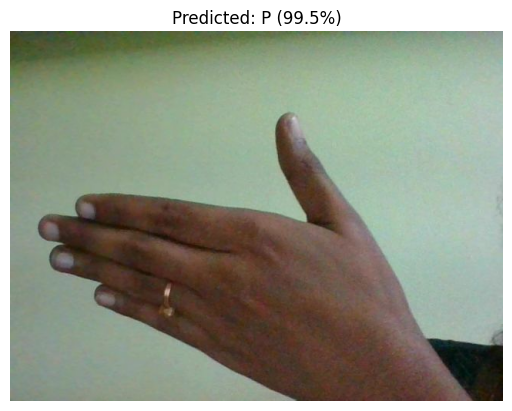

📝 Final Predicted Word: P
🗣️ Speaking: P


In [34]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.models import load_model

# STEP 2: Webcam Capture Function
def capture_image():
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const finish = document.createElement('button');
      capture.textContent = '📸 Capture Sign';
      finish.textContent = '✅ Finish Word';
      div.appendChild(capture);
      div.appendChild(finish);
      document.body.appendChild(div);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      let images = [];
      let done = false;

      capture.onclick = () => {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        images.push(canvas.toDataURL('image/jpeg', 0.8));
      };

      finish.onclick = () => { done = true; };

      while (!done) {
        await new Promise(resolve => setTimeout(resolve, 100));
      }

      stream.getVideoTracks()[0].stop();
      video.remove(); div.remove();
      return images;
    }
    takePhoto()
    ''')
    display(js)
    data = eval_js("takePhoto()")
    return data

# STEP 3: Load Model and Labels
model_path = "asl_mobilenetv2_finetuned.keras"
model = load_model(model_path)

base_path = "/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train"
labels = sorted(os.listdir(base_path))
print("✅ Loaded classes:", labels)

# STEP 4: Capture Multiple Signs
print("📸 Show signs one by one, press '📸 Capture Sign' for each, then '✅ Finish Word'")
data = capture_image()

# STEP 5: Process and Predict Each Sign
from base64 import b64decode

predicted_word = ""
for img_data in data:
    binary = b64decode(img_data.split(',')[1])
    img_array = np.frombuffer(binary, dtype=np.uint8)
    frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Preprocess
    img = cv2.resize(frame, (128,128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    pred_class = labels[np.argmax(preds)]
    confidence = np.max(preds)

    # Add to sentence
    if pred_class == "space":
        predicted_word += " "
    elif pred_class == "del" and len(predicted_word) > 0:
        predicted_word = predicted_word[:-1]
    elif pred_class not in ["nothing"]:
        predicted_word += pred_class

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {pred_class} ({confidence*100:.1f}%)")
    plt.axis('off')
    plt.show()

print("📝 Final Predicted Word:", predicted_word)

# STEP 6: Speak the Final Word (Text-to-Speech)

!pip install pyttsx3==2.90
import pyttsx3

engine = pyttsx3.init()
engine.setProperty('rate', 160)
print("🗣️ Speaking:", predicted_word)
engine.say(predicted_word)
engine.runAndWait()
